# UQ for an Optical Potential!

One of the main motivations for building an emulator is to rapidly evaluate posteriors for Bayesian optimization and uncertainty-quantification. Often, our models have high dimensional parameter spaces, and are expensive to solve, making these analyzis computationally prohibitive. In this tutorial, we will use an emulator from `rose`, combined with the Bayesian optimization package `surmise`, which uses Markov-chain Monte Carlo (MCMC) to find the best fit values on the parameters space.


We will use the emulator with 15 EIM terms and 15 basis elements from the previous tutorial, as it gives us sub per-mille error in differential cross sections while providing more than 100 samples per second:

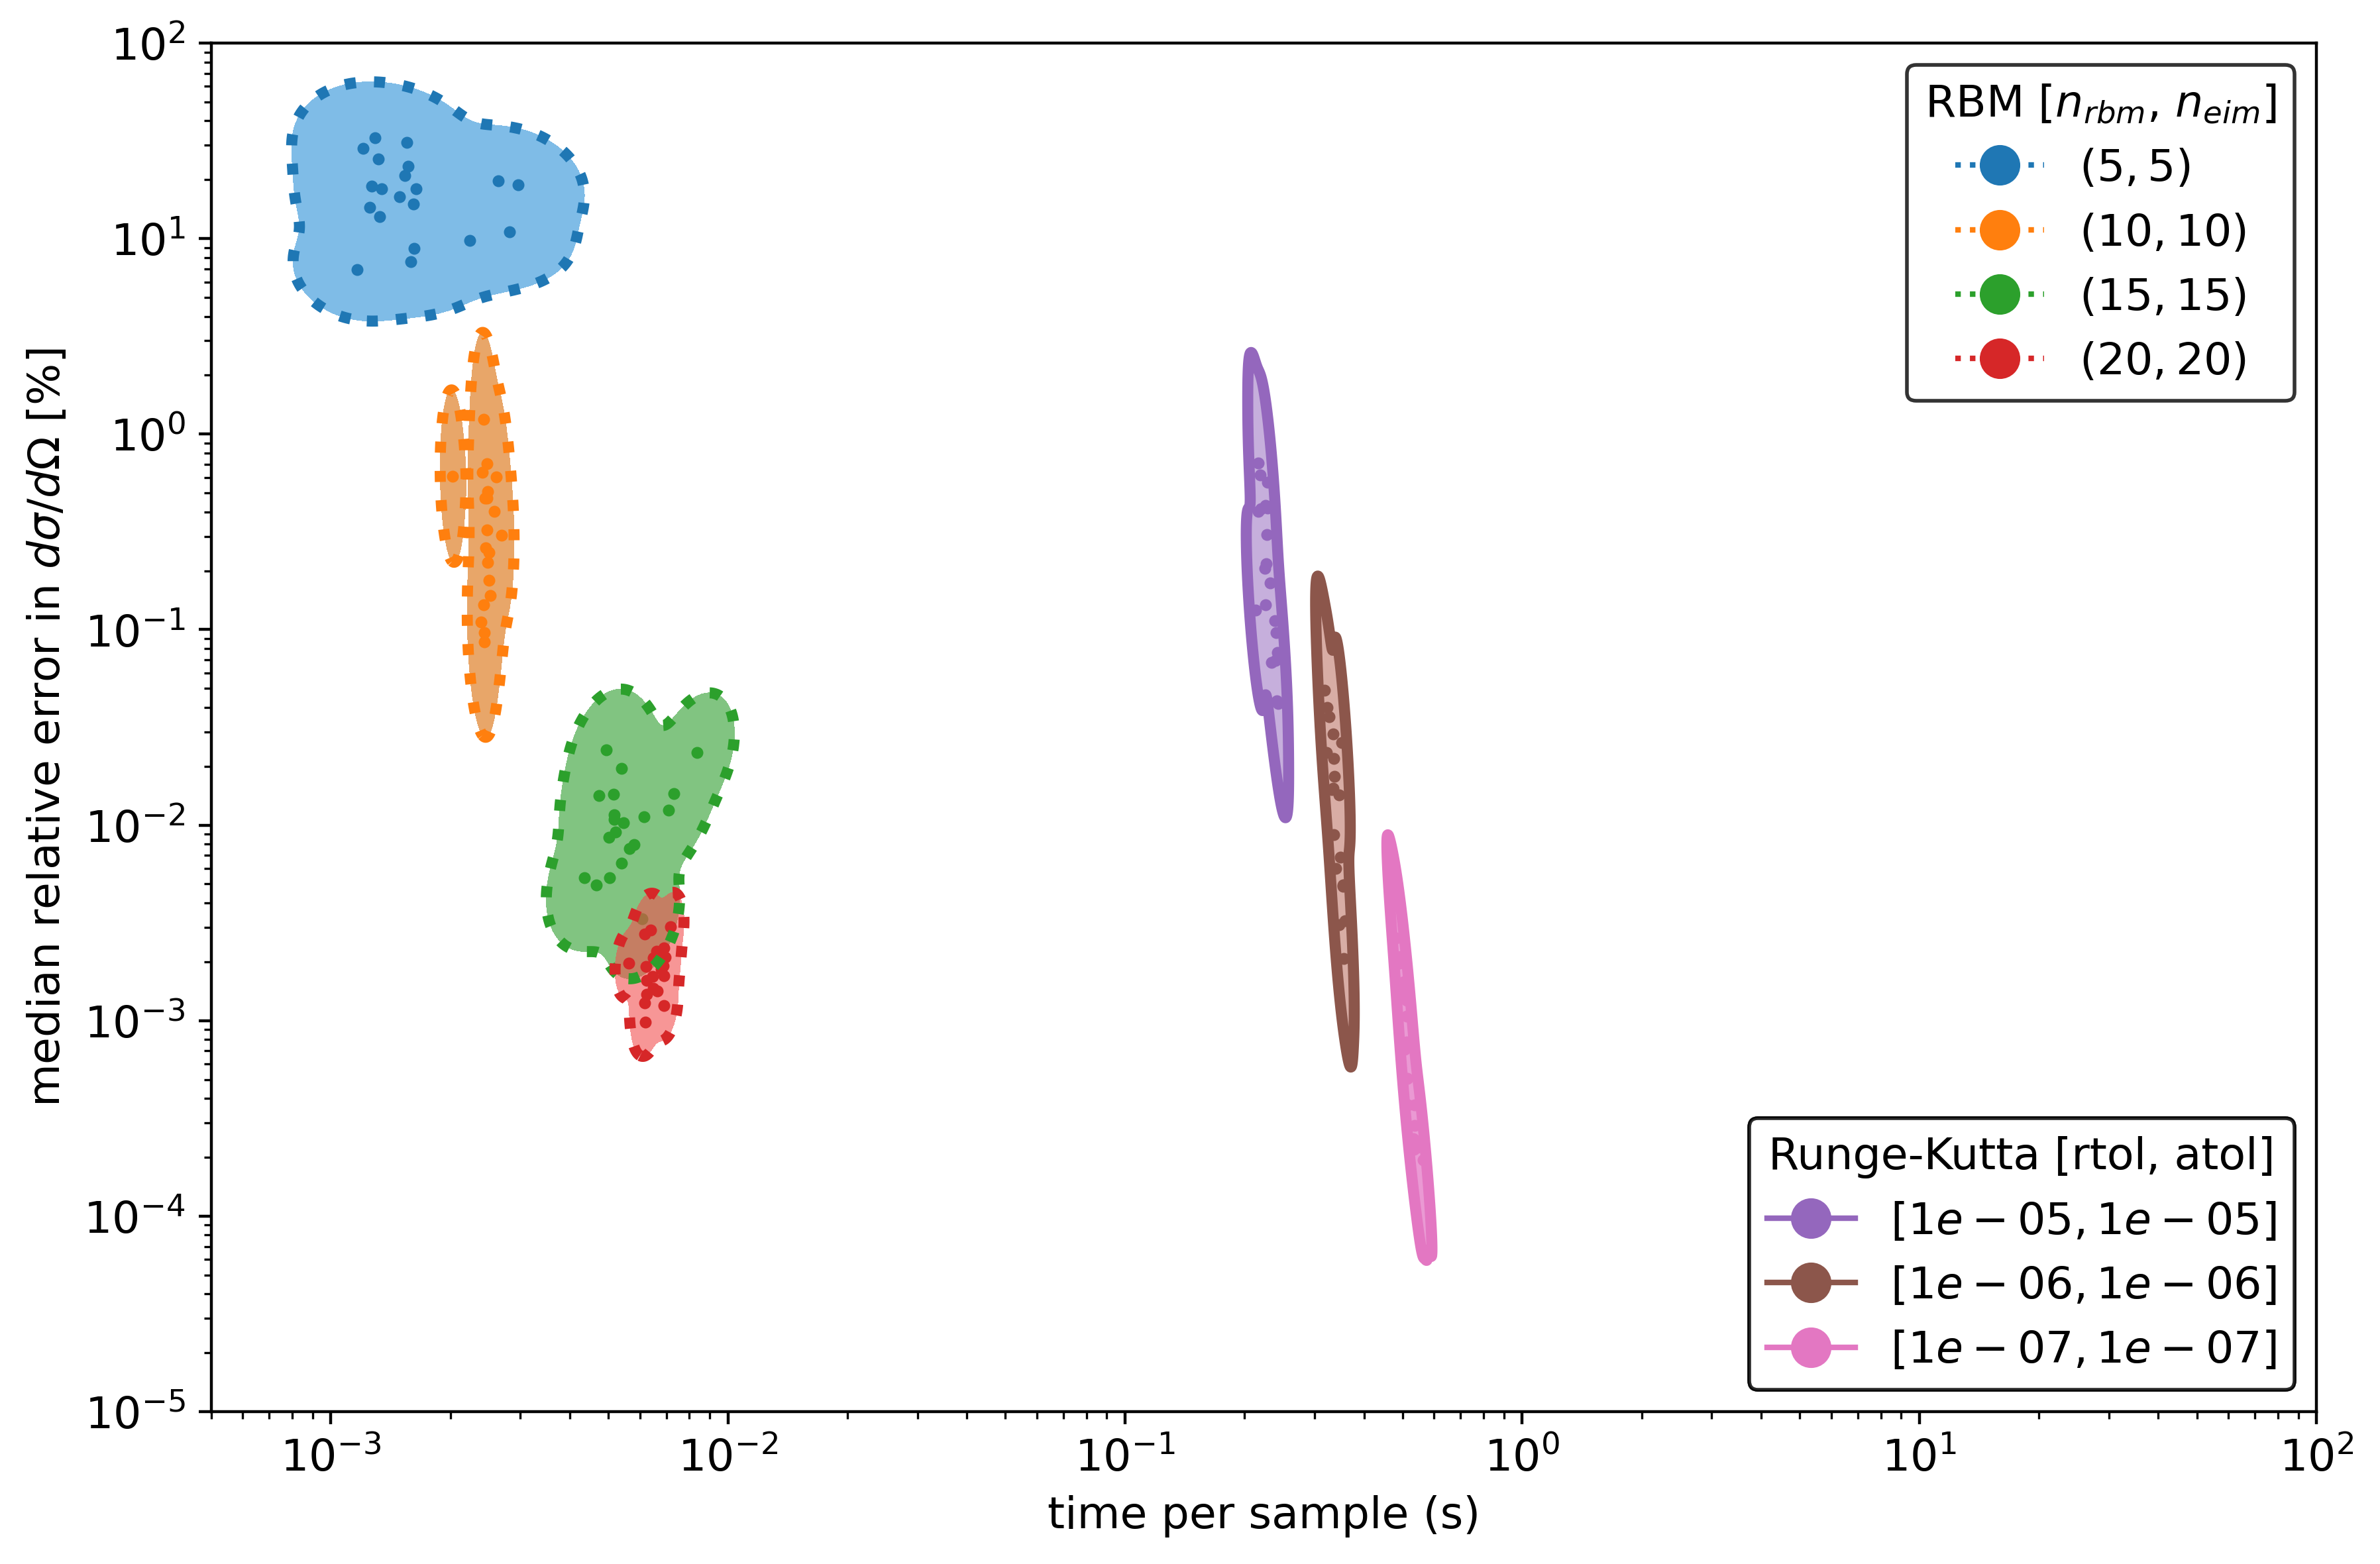

We see that the median of our emulator error was around 10^-4 and we will use that as a rough estimate of the expected error. Be mindful that, when selecting the emulator configuration (15,15) we used 50 test samples from a box of $20\%$ in the parameter space, and we expect that if our random walkers get to far from this training region the emulator quality will decrease.


First we quickly create our emulator, copying the problem setup from the previous tutorial:

In [1]:
#(if you don't have it already)
#!pip install nuclear-rose 

import rose
from numba import njit # we need to this to Just-In-Time (JIT) compile our interaction

# other nice things
import numpy as np
import time
import os
from scipy.stats import qmc

# import stuff for nice plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.stats as sps
from tqdm import tqdm
import random
import datetime
import seaborn as sns
# !pip install corner
import corner


plt.rcParams.update({'font.size': 12})
print(rose.__version__)

1.0.1.dev221+g2c12073.d20240105


In [2]:
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt
from matplotlib import rcParams
from rose.training import multiple_formatter

colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rcParams[
    "text.latex.preamble"
] = r"\usepackage{amssymb} \usepackage{amsmath} \usepackage{braket}"
plt.rc("text", usetex=True)

rcParams["legend.fontsize"] = 12
rcParams["font.size"] = 12
rcParams["font.weight"] = "normal"
rcParams["xtick.labelsize"] = 12.0
rcParams["ytick.labelsize"] = 12.0
rcParams["lines.linewidth"] = 2.0
rcParams["xtick.major.pad"] = "10"
rcParams["ytick.major.pad"] = "10"
rcParams["image.cmap"] = "BuPu"

In [3]:
# targets and projectiles defined by (A,Z)
Ca40 = (40,20)
p = (1,1)

# set up kinematics
E_lab = 14.1 # MeV - like from a DT generator
mu, E_com, k = rose.kinematics(target=Ca40, projectile=p, E_lab=E_lab)

# domain of the differential cross section; the observable we want to emulate
# we will evaluate the accuracy of our emulator by comparing dsigma/dtheta on this domain 
angles = np.linspace(1, 179, 200) * np.pi / 180

In [4]:
from rose.utility import woods_saxon, woods_saxon_prime

# total potential with a real and central term (with the same geometry)
# and imaginary surface-peaked term, but no SO coupling
@njit
def optical_potential(r, theta):
    Vv, Wv, Wd, Vso, Wso, Rv, Rd, Rso, av, ad, aso = theta
    return (1j * Wv - Vv) * woods_saxon(r, Rv, av) - (4j * ad * Wd) * woods_saxon_prime(
        r, Rd, ad
    )

# spin orbit interaction constant
mso = 1.0 / rose.constants.MASS_PION

# spin-orbit (SO) coulpling term - a function of l dot s, l being the orbital angular momentum
# and s being the spin of the neutron
@njit
def spin_orbit_potential(r, theta, ldots):
    Vv, Wv, Wd, Vso, Wso, Rv, Rd, Rso, av, ad, aso = theta
    return (Vso + 1j * Wso) * mso**2 * ldots * woods_saxon_prime(r, Rso, aso) / r


# the total number of parameters
nparams = 11

In [5]:
# This is the value of the parameters coming from the Koning-Delaroche parametrization.
# Taken from https://www-nds.iaea.org/RIPL-3/
VvKD = 46.7238
WvKD = 1.72334
WdKD = -7.2357
VsoKD = 6.1
WsoKD = -3.1

RvKD = 4.0538
RdKD = 4.4055
RsoKD = 1.01 * 40 ** (1.0 / 3.0)

avKD = 0.6718
adKD = 0.5379
asoKD = 0.60

alpha_central = np.array(
    [VvKD, WvKD, WdKD, VsoKD, WsoKD, RvKD, RdKD, RsoKD, avKD, adKD, asoKD]
)

In [6]:
scale_training = 0.2
bounds = np.array(
        [
            alpha_central - np.fabs(alpha_central * scale_training),
            alpha_central + np.fabs(alpha_central * scale_training),
        ]
    ).T

Great, we have our potential and parameters set up. Before we create our emulator, let's take a look at the experimental data we want to fit.

## Experimental data for neutron scattering on $^{40}$ Ca

Let's consider the practical example of fitting an optical potential to a differential elastic scattering cross section measurement. In particular, we will use [this measurement](http://dx.doi.org/10.1016/0029-5582(64)90087-2) from 1964 by McDonald and Robson, available [here on Exfor](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=207&subID=11611003&plus=1).


This was a measurement of 14 MeV neutrons incident on a $^{40}$ Ca target. The outgoing neutrons - also at 14 MeV, remember, this is an elastic reaction - were then measured in one of an array of detectors, each set up a different scattering angle relative to the incident beam. From the density of the target and the incident flux of the beam, the authors reconstructed $\frac{d\sigma}{d\theta}$, the scattering cross section differentiated on the scattering angle (in the center-of-mass frame). Let's first take a look at this data, and then we'll talk about how to find the best-fit parameters and their uncertainties.



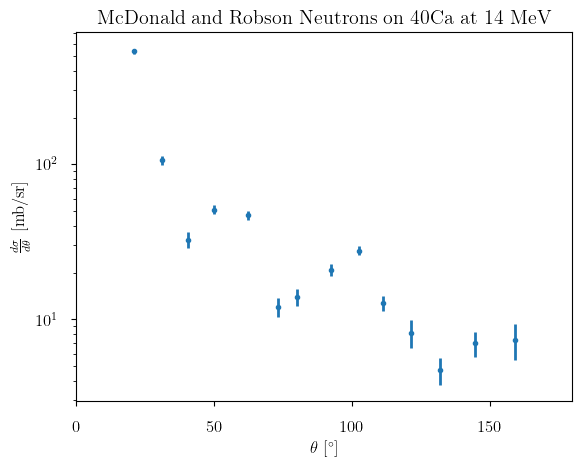

In [7]:
# Angles where d xs / s theta was measured, in degrees, 
# 0 being transmission, 180 being reflection back to the beamline

cos_theta = np.array(
    [
        0.93420,
        0.85630,
        0.76150,
        # 0.75470,  This particular measurement seems to be miss-transcribed in the data set. I replaced by the one below (41 deg to 51 deg)
        0.64279,
        0.46640,
        0.28740,
        0.17360,
        -0.0419,
        -0.2181,
        -0.3616,
        -0.5240,
        -0.6665,
        -0.8141,
        -0.9342,
    ]
)

anglesX = np.array(
    [np.arccos(cos_theta[i]) / np.pi * 180 for i in range(len(cos_theta))]
)


# corresponding experimental cross sections
dxs = np.array(
    [
        5.34e02,
        1.06e02,
        3.27e01,
        5.10e01,
        4.69e01,
        1.20e01,
        1.39e01,
        2.09e01,
        2.77e01,
        1.28e01,
        8.2e00,
        4.7e00,
        7.0e00,
        7.4e00,
    ]
)

# experimental error
dxs_err = np.array(
    [
        2.3e01,
        7.0e0,
        4.0e0,
        3.5e0,
        2.9e0,
        1.7e0,
        1.7e0,
        2.0e0,
        1.8e0,
        1.4e0,
        1.7e0,
        9.0e-01,
        1.3e0,
        1.9e0,
    ]
)

angular_resolution = 11  # degrees

plt.yscale("log")
# plt.errorbar(anglesX, dxs, dxs_err, xerr=angular_resolution, linestyle="none", marker=".")
plt.errorbar(anglesX, dxs, dxs_err, linestyle="none", marker=".")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]")
plt.ylabel(r"$\frac{d \sigma}{d \theta}$ [mb/sr]")
plt.title("McDonald and Robson Neutrons on 40Ca at 14 MeV")

plt.rc("xtick", labelsize=15)  # fontsize of the tick labels
plt.rc("ytick", labelsize=15)

plt.show()

We will build our emulator to predict the CS over the fine grid of angles so we can have relatively continous plots in the end, but we need to be sure that when calibrating with the data, the ROSE emulator is predicting only on the 14 actual points of data.

In [8]:
from rose.training import sample_params_LHC 
n_train = 80
seed_train = 142857
training_samples = sample_params_LHC(
    n_train, alpha_central, scale=scale_training, seed=seed_train
)

In [9]:
interactions = rose.InteractionEIMSpace(
    coordinate_space_potential=optical_potential,
    n_theta = nparams,
    mu=mu,
    energy=E_com,
    is_complex=True,
    spin_orbit_term=spin_orbit_potential,
    training_info=bounds,
    n_basis=15,
)

In [10]:
# let's build our first reduced basis emulator
base_solver = rose.SchroedingerEquation.make_base_solver(
    s_0=6 * np.pi, rk_tols=[1e-10, 1e-10], domain=np.array([1e-8, 8 * np.pi])
)
rose_emulator = rose.ScatteringAmplitudeEmulator.from_train(
    interactions,
    training_samples,
    n_basis=15, 
    angles=angles,
    base_solver=base_solver,
    scale=True,
    use_svd=True,
)

100%|███████████████████████████████████████████| 16/16 [03:34<00:00, 13.43s/it]


## Specifying the Prior

In [11]:
# In this default we are assuming uncorrelated Gaussian priors. 
# Advanced users can provide covariance matrices for correlations

# Specifying the priors, we believe the answer that explains the data shouldn't be too 
# far away from the KD parameters
alpha_central_prior = alpha_central

# We are using Gaussian priors with a standard deviation of 15% of their respective centers
sigma_prior = [abs(param_val * 0.15) for param_val in alpha_central_prior]

# We use a smaller scale for the starting values of the MCMC chains so that we minimize 
# the chances of one starting in a negative value of the diffuseness or the radii

# This scale is very important: since the optical potential posterior parameter surface 
# is highly multimodal we would like to limit ourself for this tutorial to study a vicinity
# of the main mode closer to our prior. We will start our walkers very close to the prior 
# center.
MCMC_scale = [abs(param_val * 0.01) for param_val in alpha_central_prior]

# This error scale comes from the CAT plot we showed at the begining. 
emulator_error = 5 * 10 ** (-4)

## Going Bayesian with Surmise

We will use `surmise`, another BAND-developed package for connecting all the tools and softwares (such as our `rose` emulator) for performing Bayesian analysis.

Check out surmise's documentation webpage for more information: https://surmise.readthedocs.io/en/latest/

In [12]:
# Be sure to install this version of surmise

!pip install surmise

In [13]:
# check for surmise-0.2.1.dev14
import surmise
import importlib

importlib.reload(surmise)
print(surmise.__version__)

0.2.1


Our sample rate for the emulator is around 10 miliseconds, which means around 6k samples per minute. We are choosing a relatively small amount of samples and chains to have the calibration done in a couple of minutes. You can of course run it for longer and obtain millions of samples to build very detailed and rich corner plots.

In [14]:
from surmise.emulation import emulator
from surmise.calibration import calibrator

X = np.copy(anglesX) / 180 * np.pi
y = np.copy(dxs)  # data we want to fit
yerr = np.copy(dxs_err)  # err in data

step_sizes0 = 0.02 * np.abs(alpha_central)

nsamples = 20000
total_chains = 40
ncores = 8
burn_samples0 = 500

In [15]:
class prior_scattering:
    """This defines the class instance of priors provided to the method."""

    def lpdf(theta):
        total_prior_pdf = sps.norm.logpdf(
            theta[:, 0], alpha_central_prior[0], sigma_prior[0]
        )

        for i in range(1, len(alpha_central_prior)):
            total_prior_pdf = total_prior_pdf + sps.norm.logpdf(
                theta[:, i], alpha_central_prior[i], sigma_prior[i]
            )

        return (total_prior_pdf).reshape((len(theta), 1))

    def rnd(n):
        total_rand_samples = np.empty((len(alpha_central_prior),n))
        for i in range(len(alpha_central_prior)):
            smp = sps.norm.rvs(alpha_central_prior[i], MCMC_scale[i], size=n)
            total_rand_samples[i,...] = smp
        return total_rand_samples.T

In [16]:
def calibration_runner(rbm, x, y, obsvar, test_params, numsamp, i, caldir):
    cal = calibrator(
        emu=rbm,
        y=y,
        x=x,
        thetaprior=prior_scattering,
        method="directbayes",
        yvar=obsvar,
        args={
            "theta0": test_params.reshape(1, nparams),
            "sampler": "metropolis_hastings",
            "numsamp": nsamples,
            "stepType": "normal",
            "stepParam": step_sizes0,
            "burnSamples": burn_samples0,
            "verbose": True,
        },
    )

    calfile = os.path.join(caldir, "caltheta_{}.out".format(i))
    np.savetxt(calfile, cal.info["thetarnd"])

    return cal.info["thetarnd"]

In [17]:
random.seed(142857)

obsvar = 1.0 * np.square(yerr)

caldir = os.path.join(
    os.getcwd(), "Cal-" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
)
os.makedirs(caldir, exist_ok=True)

rand_params = prior_scattering.rnd(total_chains)

In [18]:
rbm = emulator(
    method="nuclear-ROSE",
    args={
        "rose_emu": rose_emulator,
        "emu_variance_constant": emulator_error,
        "angle_atol": 1e-1,
    },
)

In [ ]:
%%time
sep_chains = []
chain0 = calibration_runner(rbm, X, y, obsvar, rand_params[0], nsamples, 0, caldir)
sep_chains.append(chain0)
all_chains = chain0

for ij in tqdm(range(total_chains - 1)):
    current_cal = calibration_runner(
        rbm, X, y, obsvar, rand_params[ij], nsamples, ij + 1, caldir
    )

    all_chains = np.vstack(
        (
            all_chains,
            current_cal,
        )
    )

    sep_chains.append(current_cal)

sep_chains = np.array(sep_chains)

Final Acceptance Rate:  0.09745


  0%|                                                    | 0/39 [00:00<?, ?it/s]

Final Acceptance Rate:  0.09105


  3%|█                                        | 1/39 [03:36<2:17:14, 216.68s/it]

Final Acceptance Rate:  0.0896


  5%|██                                       | 2/39 [06:51<2:05:38, 203.74s/it]

Final Acceptance Rate:  0.097


  8%|███▏                                     | 3/39 [11:32<2:23:29, 239.16s/it]

In [ ]:
# Getting the same number of samples from the prior so we can compare the two
samples_prior = np.empty((len(alpha_central_prior),10000))
for i in range(len(alpha_central_prior)):
    samples_prior[i] = sps.norm.rvs(alpha_central_prior[i], sigma_prior[i], size=10000)

samples_prior = samples_prior.T

## Plotting the results of the calibration

In [ ]:
# The plotting routinge to make the gorgeous corner plots! For some reason we have to run 
# it twice to make the label size for the ticks to be correct

plt.rc("xtick", labelsize=30)
plt.rc("ytick", labelsize=30)

bins_target = 20
ws = [
    abs(max(all_chains[:, i]) - min(all_chains[:, i])) / bins_target
    for i in range(len(all_chains.T))
]

figure = corner.corner(
    samples_prior,
    labels=[
        "$V_v$",
        "$W_v$",
        "$W_d$",
        "$V_{so}$",
        "$W_{so}$",
        "$R_v$",
        "$R_d$",
        "$R_{so}$",
        "$a_v$",
        "$a_d$",
        "$a_{so}$",
    ],
    labelpad=0.2,
    weights=np.full(len(samples_prior), (len(all_chains)) / (len(samples_prior))),
    bins=[
        int(abs(max(samples_prior[:, i]) - min(samples_prior[:, i])) / ws[i])
        for i in range(len(samples_prior.T))
    ],
    color="b",
    # bins=20,
    label_kwargs={"fontsize": 40},
    hist_kwargs={"linewidth": 3},
    quantiles=None,
    truths=alpha_central,
    truth_color="r",
    smooth=(1.7),
    smooth1d=1.0,
    max_n_ticks=2
)


corner.corner(
    all_chains,
    fig=figure,
    labels=[
        "$V_v$",
        "$W_v$",
        "$W_d$",
        "$V_{so}$",
        "$W_{so}$",
        "$R_v$",
        "$R_d$",
        "$R_{so}$",
        "$a_v$",
        "$a_d$",
        "$a_{so}$",
    ],
    labelpad=0.2,
    # bins=20,
    bins=[
        int(abs(max(all_chains[:, i]) - min(all_chains[:, i])) / ws[i])
        for i in range(len(all_chains.T))
    ],
    label_kwargs={"fontsize": 40},
    hist_kwargs={"linewidth": 3},
    quantiles=None,
    truths=alpha_central,
    truth_color="r",
    smooth=(1.7),
    smooth1d=1.0,
    max_n_ticks=2
)


dim = len(all_chains[0])
ranges = [
    [min(all_chains[:, i]), max(all_chains[:, i])] for i in range(len(all_chains.T))
]

axes = np.array(figure.axes).reshape((dim, dim))
# print()
for i in range(dim):
    ax = axes[i, i]
    ax.set_xlim(ranges[i][0], ranges[i][1])

    for j in range(i):
        ax = axes[i, j]
        ax.set_ylim(ranges[i][0], ranges[i][1])
        ax.set_xlim(ranges[j][0], ranges[j][1])


width = 24
height = 18
figure.set_size_inches(width, height)

plt.savefig("corner_ca40_cal.pdf", bbox_inches='tight',)

Very interesting! In red we can see the original parametrization by Koning-Delaroche that we used as the center of our prior, the blue lines are the actual prior, and the black ones the posterior. Most parameters are more or less around that value, while some shifted appreciably.Some parameters are very well constrained by the data, while others seem to just be constrained by the prior. 

Thanks to ROSE, we now can make these kinds of analysis VERY fast!

In [ ]:
labels = [
    "$V_v$",
    "$W_v$",
    "$W_d$",
    "$V_{so}$",
    "$W_{so}$",
    "$R_v$",
    "$R_d$",
    "$R_{so}$",
    "$a_v$",
    "$a_d$",
    "$a_{so}$",
]

Below we plot the parameters that all the chains, concatenated together, explored. The horizontal red lines are the KD values

In [ ]:
XAll = np.arange(len(anglesX))

plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)
fig, axs = plt.subplots(nparams, 1, figsize=(12, 12), sharex="all")

for i in range(nparams):
    axs[i].axhline(y=alpha_central[i], color="r")
    axs[i].plot(sep_chains[:, :, i].T, alpha=0.65)
    axs[i].set_ylabel(labels[i], fontsize=18)

plt.xlabel("MCMC samples")
plt.show()

## Plotting our final calibrated model alongside the data

In [ ]:
XAll = np.arange(len(anglesX))

In [ ]:
# %#%time
rng = np.random.default_rng()
theta_rand = rng.choice(all_chains, (1000), replace=False)

In [ ]:
rndm_m = np.array(
    [rose_emulator.emulate_dsdo(theta_rand[i]) for i in range(len(theta_rand))]
)

In [ ]:
# rndm_m = rbm(XAll, theta_rand).mean().T

In [ ]:
KD_cs = rose_emulator.emulate_dsdo(alpha_central)

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4),dpi=600)
median = np.percentile(rndm_m, 50, axis=0)
upper = np.abs(np.percentile(rndm_m, 97.5, axis=0))
lower = np.abs(np.percentile(rndm_m, 2.5, axis=0))

axs.plot(angles, median, color="C0", label="Median Prediction")
axs.fill_between(
    angles,
    lower,
    upper,
    color="C0",
    alpha=0.5,
    label=r"95$^{\rm{th}}$ predictive interval",
)

axs.scatter(anglesX * np.pi / 180, y, s=10, c="r", alpha=0.5, label="Mcdonald (1964)")
axs.errorbar(anglesX * np.pi / 180, y, yerr=2 * yerr, fmt="o", alpha=0.5, c="r")

axs.set_yscale("log")

axs.set_xlabel(r"$\theta$ [radians]", fontsize=12)
axs.set_ylabel(r"$d\sigma/d\Omega$ [mb/sr] ", fontsize=12)

axs.plot(angles, KD_cs, c="k", linestyle="dashed", label="Original KD")

axs.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 6))
axs.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter(denominator=6)))

plt.text(0.7, 5e2, r"$^{40}\rm{Ca}(n,n)$", fontsize=14)
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig("Ca40n_predpost.pdf", bbox_inches='tight',)

And we are done! This is truly a Bayesian calibration of our Optical potential and, as we can see, it really learned something from the data. Compare the black dashed line, the original KD global parametrization, with the median and 95% confidence intervals of our calibrated model. 

Now the power is yours, go ahead on many adventures and calibrate many reaction models with all the available data. 

                                                                                                                                The ROSE team
